# Обзор датасета и создание нового

In [ ]:
%pip install pystoi

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import hilbert, find_peaks, medfilt, spectrogram, butter, filtfilt
import IPython.display as ipd
from pystoi import stoi
from exercises_blank import energy_gmm_vad

In [16]:
path_to_wav_folder = '/home/danya/datasets/speech_thesisis/'

Основная частота сигнала: 800.00 Hz


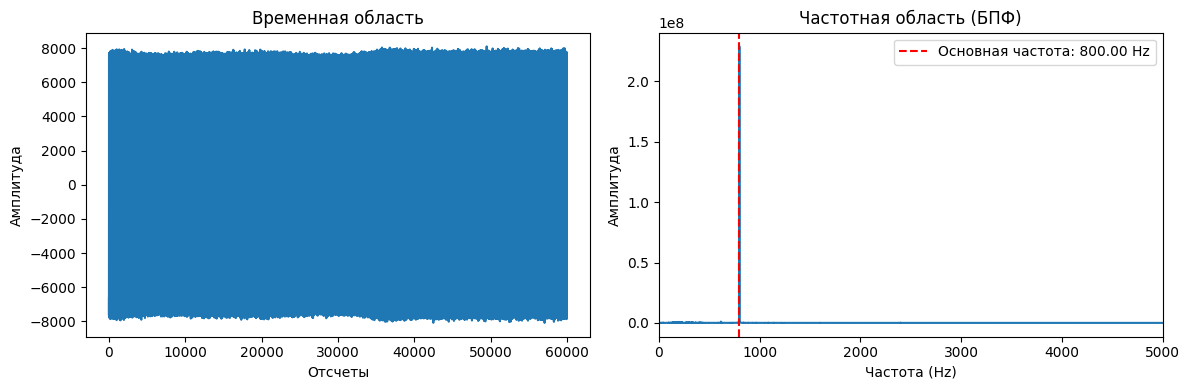

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

sample_rate, audio_data = wavfile.read(path_to_wav_folder + 'Рина_8-1м.wav')

segment = audio_data[140000:200000]
if len(segment.shape) > 1:
    segment = segment[:, 0]

fft_result = np.fft.fft(segment)
fft_magnitude = np.abs(fft_result)

n = len(segment)
freqs = np.fft.fftfreq(n, 1/sample_rate)

positive_freq_idx = freqs > 0
freqs_positive = freqs[positive_freq_idx]
fft_positive = fft_magnitude[positive_freq_idx]
max_amp_idx = np.argmax(fft_positive)
dominant_frequency = freqs_positive[max_amp_idx]

print(f"Основная частота сигнала: {dominant_frequency:.2f} Hz")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(segment)
plt.title('Временная область')
plt.xlabel('Отсчеты')
plt.ylabel('Амплитуда')

plt.subplot(1, 2, 2)
plt.plot(freqs_positive, fft_positive)
plt.axvline(x=dominant_frequency, color='r', linestyle='--', label=f'Основная частота: {dominant_frequency:.2f} Hz')
plt.title('Частотная область (БПФ)')
plt.xlabel('Частота (Hz)')
plt.ylabel('Амплитуда')
plt.legend()
plt.xlim(0, 5000)

plt.tight_layout()
plt.show()

In [20]:
def plot_waveform_with_envelope(waveform, sample_rate, title):
    waveform = waveform / np.max(np.abs(waveform))
    
    window_size = int(0.02 * sample_rate)
    hop_size = int(window_size / 4)
    
    amplitude_envelope_windowed = np.zeros_like(waveform)
    
    for i in range(0, len(waveform) - window_size, hop_size):
        window = waveform[i:i + window_size]
        max_val = np.max(np.abs(window))
        amplitude_envelope_windowed[i:i + hop_size] = max_val
    
    if len(waveform) % hop_size != 0:
        remaining = len(waveform) - (len(waveform) // hop_size) * hop_size
        amplitude_envelope_windowed[-remaining:] = amplitude_envelope_windowed[-(remaining + hop_size)]
    
    amplitude_envelope_windowed = medfilt(amplitude_envelope_windowed, kernel_size=window_size//10)
    
    analytic_signal = hilbert(waveform)
    amplitude_envelope_hilbert = np.abs(analytic_signal)
    
    time = np.arange(len(waveform)) / sample_rate
    
    plt.figure(figsize=(12, 8))
    
    plt.plot(time, waveform, label='Осциллограмма', alpha=0.7, color='blue', linewidth=0.8)
    plt.plot(time, amplitude_envelope_windowed, label='Огибающая (оконная)', color='red', linewidth=2)
    plt.plot(time, amplitude_envelope_hilbert, label='Огибающая (Гильберт)', color='orange', linewidth=1.5, alpha=0.7)
    
    plt.title(title)
    plt.xlabel('Время (с)')
    plt.ylabel('Амплитуда')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

In [21]:
def plot_waveform_with_envelope_simple(waveform, sample_rate, title):
    waveform = waveform / np.max(np.abs(waveform))
    
    window_size = int(0.01 * sample_rate)
    hop_size = max(1, window_size // 8)
    
    envelope = np.zeros(len(waveform))
    
    for i in range(0, len(waveform), hop_size):
        end_idx = min(i + window_size, len(waveform))
        window = waveform[i:end_idx]
        if len(window) > 0:
            max_val = np.max(np.abs(window))
            fill_end = min(i + hop_size, len(waveform))
            envelope[i:fill_end] = max_val
    
    smooth_window = max(1, window_size // 4)
    if smooth_window > 1:
        envelope = np.convolve(envelope, np.ones(smooth_window)/smooth_window, mode='same')
    
    time = np.arange(len(waveform)) / sample_rate
    
    plt.figure(figsize=(12, 6))
    plt.plot(time, waveform, label='Осциллограмма', alpha=0.5, color='blue', linewidth=1)
    plt.plot(time, envelope, label='Огибающая', color='red', linewidth=2)
    
    plt.title(title)
    plt.xlabel('Время (с)')
    plt.ylabel('Амплитуда')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

In [22]:
def process_wav_files(folder_path, method='simple'):
    wav_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.wav')]
    
    if not wav_files:
        print("В указанной директории не найдено WAV-файлов.")
        return
    
    for wav_file in wav_files:
        file_path = os.path.join(folder_path, wav_file)
        
        sample_rate, audio_data = wavfile.read(file_path)
        
        if len(audio_data.shape) > 1:
            audio_data = audio_data[:, 0]
        
        len_data = len(audio_data) // 10
        
        print(f"Обработка файла: {wav_file}")
        print(f"Частота дискретизации: {sample_rate} Гц")
        print(f"Длительность: {len(audio_data)/sample_rate:.2f} секунд")
        
        if method == 'simple':
            plot_waveform_with_envelope_simple(audio_data[:len_data], sample_rate, f'Осциллограмма и огибающая\n{wav_file}')
        else:
            plot_waveform_with_envelope(audio_data[:len_data], sample_rate, f'Осциллограмма и огибающая\n{wav_file}')
    
    plt.show()

## Огибающие

Обработка файла: Рина_4-1м.wav
Частота дискретизации: 16000 Гц
Длительность: 51.94 секунд
Обработка файла: Рина_2-1м.wav
Частота дискретизации: 16000 Гц
Длительность: 51.94 секунд
Обработка файла: Рина_8-1м.wav
Частота дискретизации: 16000 Гц
Длительность: 73.47 секунд
Обработка файла: Рина_1-1м.wav
Частота дискретизации: 16000 Гц
Длительность: 51.93 секунд


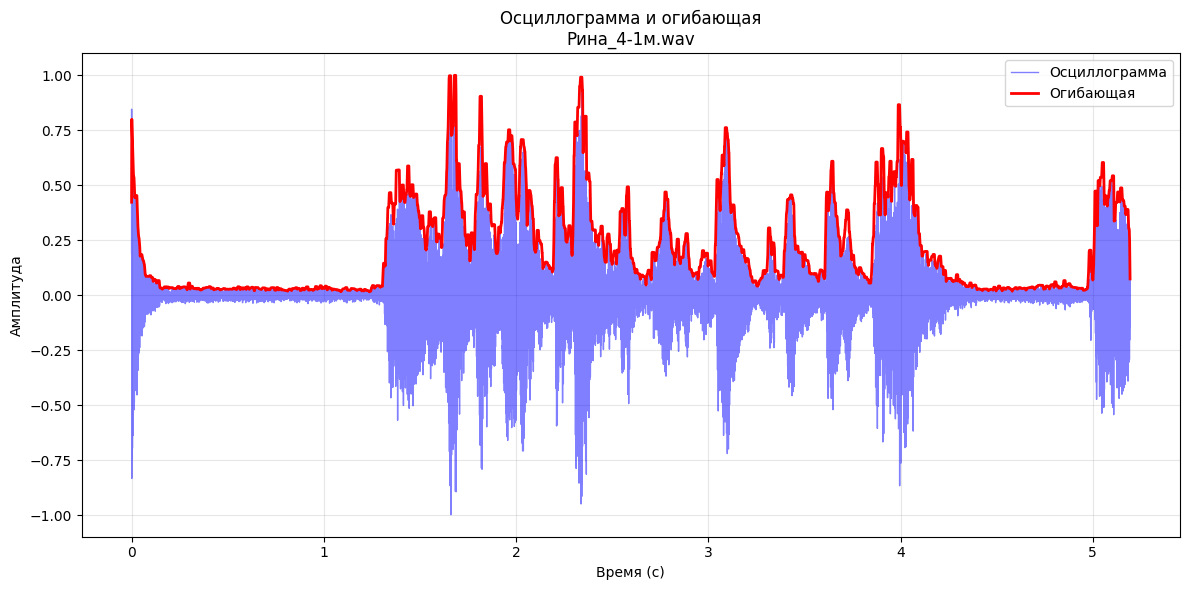

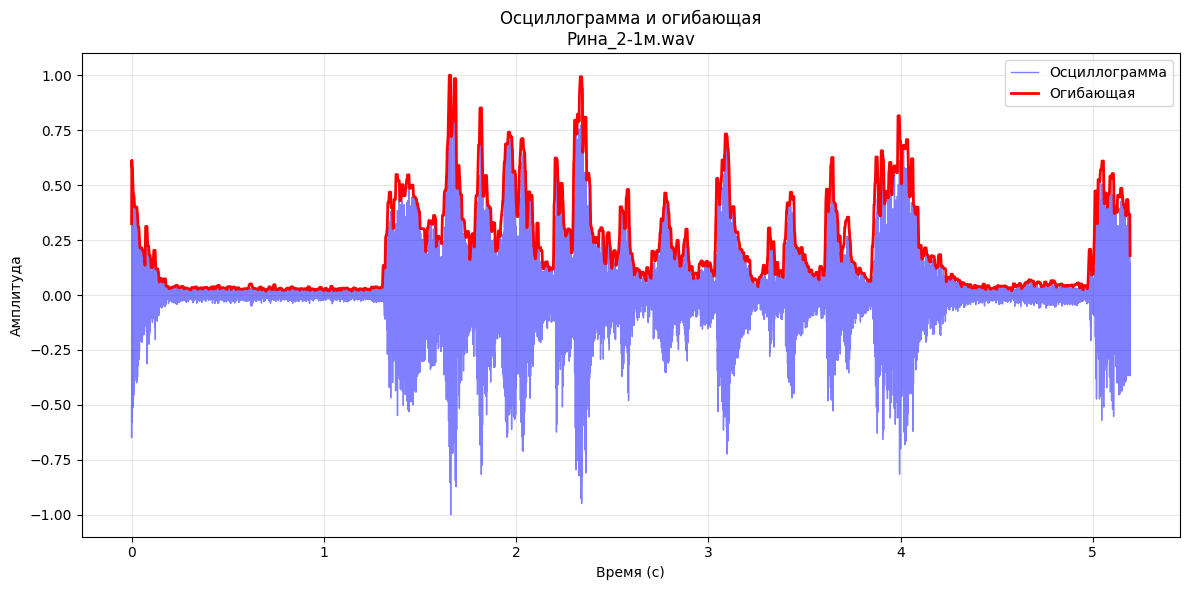

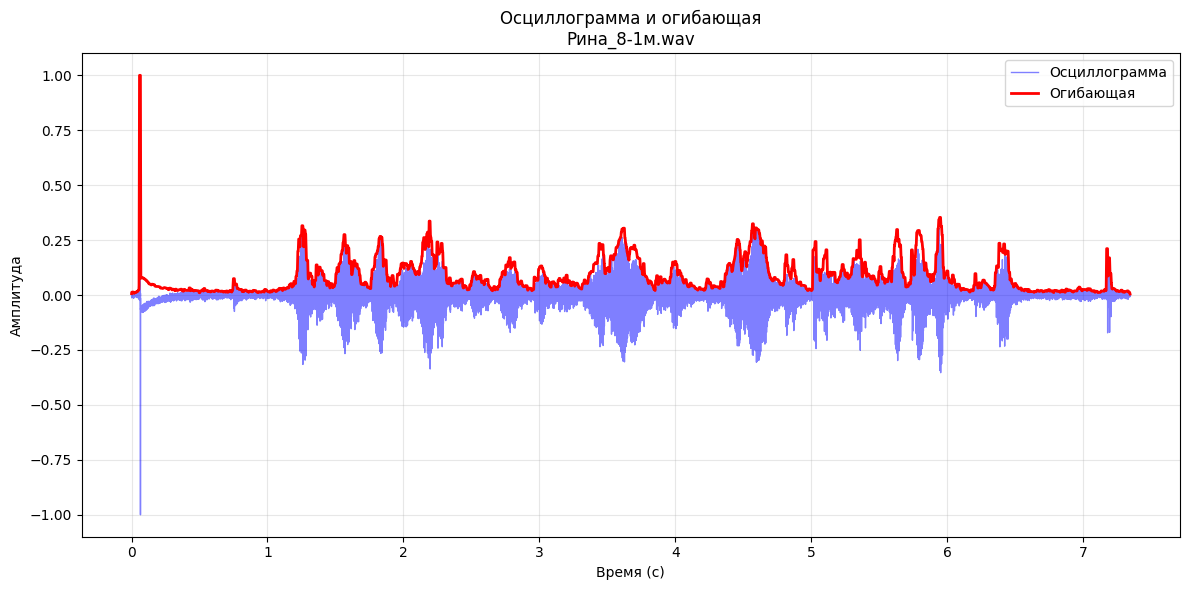

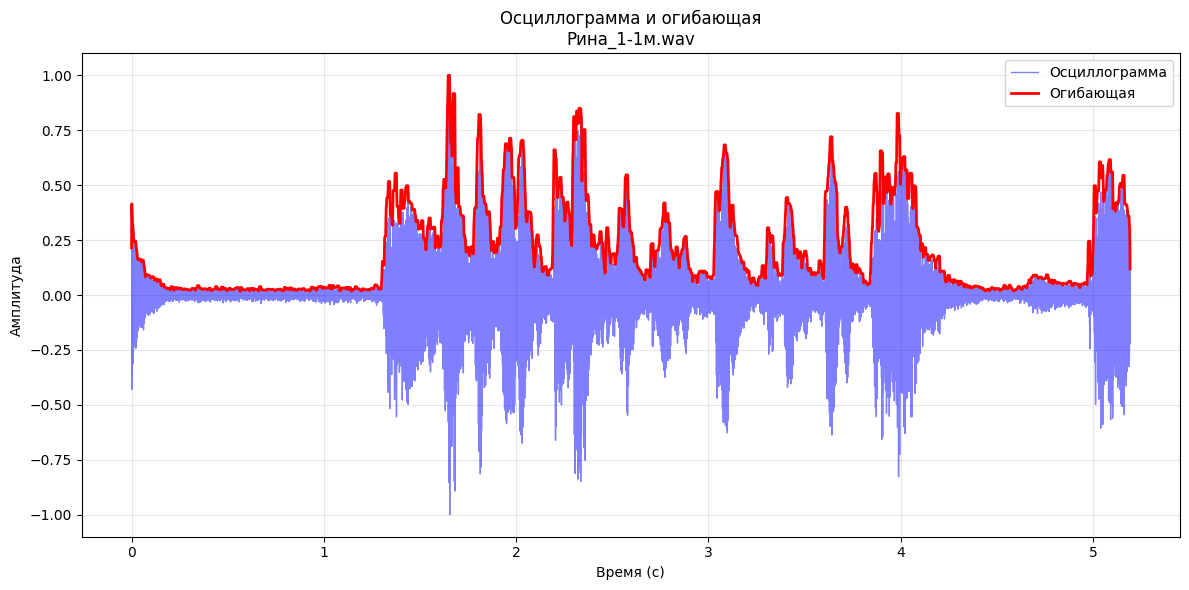

In [23]:
process_wav_files(path_to_wav_folder, method='simple')


# STOI

In [1]:
def gauss_pdf(x, mu, sigma):
    return (1.0 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

In [2]:
def bandpass_filter(signal, sample_rate, lowcut=750, highcut=850, order=4):
    nyquist = 0.5 * sample_rate
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

In [3]:
def detect_800hz_tone(signal, sample_rate, tone_freq=800, threshold=0.3, min_duration=0.5):
    filtered_signal = bandpass_filter(signal, sample_rate, tone_freq-50, tone_freq+50)
    
    envelope = np.abs(filtered_signal)
    
    smooth_window = int(0.02 * sample_rate)
    if smooth_window > 1:
        envelope_smooth = np.convolve(envelope, np.ones(smooth_window)/smooth_window, mode='same')
    else:
        envelope_smooth = envelope
    
    envelope_norm = envelope_smooth / np.max(envelope_smooth)
    
    tone_mask = envelope_norm > threshold
    
    tone_segments = []
    in_tone = False
    start_idx = 0
    
    for i in range(len(tone_mask)):
        if tone_mask[i] and not in_tone:
            in_tone = True
            start_idx = i
        elif not tone_mask[i] and in_tone:
            in_tone = False
            end_idx = i
            duration = (end_idx - start_idx) / sample_rate
            if duration >= min_duration:
                tone_segments.append((start_idx, end_idx, duration))
    
    if in_tone:
        duration = (len(tone_mask) - start_idx) / sample_rate
        if duration >= min_duration:
            tone_segments.append((start_idx, len(tone_mask), duration))
    
    if tone_segments:
        tone_segments.sort(key=lambda x: np.mean(envelope_norm[x[0]:x[1]]), reverse=True)
        
        best_tone_start, best_tone_end, best_duration = tone_segments[0]
        
        tone_end_sample = min(best_tone_end + int(0.1 * sample_rate), len(signal))
        
        return tone_end_sample
    else:
        return 0

In [4]:
def extract_speech_segments(signal, vad_markup, sample_rate, min_silence_duration=0.1):
    speech_segments = []
    in_speech = False
    start_idx = 0
    
    silence_samples = int(min_silence_duration * sample_rate)
    
    for i in range(len(vad_markup)):
        if vad_markup[i] == 1 and not in_speech:
            in_speech = True
            start_idx = max(0, i - silence_samples // 4)
        elif vad_markup[i] == 0 and in_speech:
            if i + silence_samples < len(vad_markup):
                if np.all(vad_markup[i:i+silence_samples] == 0):
                    in_speech = False
                    end_idx = min(len(signal), i + silence_samples // 4)
                    speech_segments.append(signal[start_idx:end_idx])
            else:
                in_speech = False
                speech_segments.append(signal[start_idx:i])
    
    if in_speech:
        speech_segments.append(signal[start_idx:])
    
    if speech_segments:
        continuous_speech = np.concatenate(speech_segments)
        
        pause_duration = int(0.05 * sample_rate)
        pause = np.zeros(pause_duration)
        
        final_speech = speech_segments[0]
        for segment in speech_segments[1:]:
            final_speech = np.concatenate([final_speech, pause, segment])
        
        return final_speech, speech_segments
    else:
        return np.array([]), []

In [5]:
def apply_vad_filter(signal, vad_markup):
    signal_filtered = signal.copy()
    signal_filtered[vad_markup == 0] = 0
    return signal_filtered

In [6]:
def extract_audio_after_tone(signal, sample_rate, tone_end_sample, duration_sec=10):
    start_sample = tone_end_sample
    end_sample = min(len(signal), start_sample + duration_sec * sample_rate)
    
    if end_sample > start_sample:
        return signal[start_sample:end_sample], start_sample, end_sample
    else:
        return np.array([]), start_sample, start_sample

In [7]:
def load_audio_file(file_path):
    sample_rate, audio_data = wavfile.read(file_path)
    
    if len(audio_data.shape) > 1:
        audio_data = audio_data[:, 0]
    
    audio_data = audio_data.astype('float32')
    audio_data = audio_data / np.max(np.abs(audio_data))
    
    if '8-1м' in file_path:
        max_duration = 25
    else:
        max_duration = 15
        
    max_samples = min(len(audio_data), max_duration * sample_rate)
    audio_segment = audio_data[:max_samples]
    
    return audio_segment, sample_rate

In [8]:
def process_file_with_vad_after_tone(file_path):
    sample_rate, audio_data = wavfile.read(file_path)
    
    if len(audio_data.shape) > 1:
        audio_data = audio_data[:, 0]
    
    audio_data = audio_data.astype('float32')
    audio_data = audio_data / np.max(np.abs(audio_data))
    
    if '8-1м' in file_path:
        max_duration = 25
    else:
        max_duration = 15
        
    max_samples = min(len(audio_data), max_duration * sample_rate)
    audio_segment = audio_data[:max_samples]
    
    tone_end_sample = detect_800hz_tone(audio_segment, sample_rate)
    
    speech_start_sample = tone_end_sample
    speech_signal = audio_segment[speech_start_sample:]
    
    if len(speech_signal) == 0:
        return None, sample_rate, 0, audio_segment, None, speech_start_sample
    
    vad_markup_speech = energy_gmm_vad(
        signal=speech_signal,
        window=320,
        shift=160,
        gauss_pdf=gauss_pdf,
        n_realignment=10,
        vad_thr=0.5,
        mask_size_morph_filt=5
    )
    
    full_vad_markup = np.zeros_like(audio_segment)
    full_vad_markup[speech_start_sample:speech_start_sample + len(vad_markup_speech)] = vad_markup_speech
    
    continuous_speech, speech_segments = extract_speech_segments(speech_signal, vad_markup_speech, sample_rate)
    
    return continuous_speech, sample_rate, len(speech_segments), audio_segment, full_vad_markup, speech_start_sample

In [9]:
def calculate_stoi_after_tone(reference_file, processed_files_folder, results):
    stoi_results = {}
    
    ref_audio, ref_sample_rate = load_audio_file(reference_file)
    
    if ref_audio is None:
        return stoi_results
    
    ref_tone_end = detect_800hz_tone(ref_audio, ref_sample_rate)
    ref_audio_after_tone, ref_start, ref_end = extract_audio_after_tone(ref_audio, ref_sample_rate, ref_tone_end, duration_sec=10)
    
    if len(ref_audio_after_tone) == 0:
        return stoi_results
    
    for filename, result_data in results.items():
        if result_data['original_audio'] is not None and len(result_data['original_audio']) > 0:
            original_audio = result_data['original_audio']
            original_sample_rate = result_data['sample_rate']
            speech_start_sample = result_data['speech_start_sample']
            
            test_audio_after_tone, test_start, test_end = extract_audio_after_tone(
                original_audio, original_sample_rate, speech_start_sample, duration_sec=10
            )
            
            if len(test_audio_after_tone) == 0:
                stoi_results[filename] = None
                continue
            
            if original_sample_rate != ref_sample_rate:
                from scipy import signal
                num_samples = int(len(test_audio_after_tone) * ref_sample_rate / original_sample_rate)
                test_audio_resampled = signal.resample(test_audio_after_tone, num_samples)
            else:
                test_audio_resampled = test_audio_after_tone
            
            min_len = min(len(ref_audio_after_tone), len(test_audio_resampled))
            ref_segment = ref_audio_after_tone[:min_len]
            test_segment = test_audio_resampled[:min_len]
            
            if min_len < ref_sample_rate * 5:
                stoi_results[filename] = None
                continue
            
            stoi_score = stoi(ref_segment, test_segment, ref_sample_rate, extended=False)
            stoi_results[filename] = stoi_score
    
    return stoi_results

In [10]:
def plot_waveform_with_tone_detection(waveform, vad_markup, sample_rate, tone_position, title):
    waveform = waveform / np.max(np.abs(waveform))
    time = np.arange(len(waveform)) / sample_rate
    tone_time = tone_position / sample_rate
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
    
    ax1.plot(time, waveform, label='Осциллограмма', alpha=0.7, color='blue', linewidth=1)
    ax1.axvline(x=tone_time, color='red', linestyle='--', alpha=0.8, linewidth=2, label='Окончание тона 800 Гц')
    
    analysis_end = min(tone_time + 10, time[-1])
    ax1.axvspan(tone_time, analysis_end, alpha=0.2, color='green', label='Область для STOI анализа')
    
    ax1.set_ylabel('Амплитуда')
    ax1.set_title(f'{title}')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.fill_between(time, 0, vad_markup, alpha=0.7, color='green', label='VAD разметка')
    ax2.plot(time, vad_markup, color='darkgreen', linewidth=1)
    ax2.axvline(x=tone_time, color='red', linestyle='--', alpha=0.8, linewidth=2, label='Окончание тона 800 Гц')
    ax2.set_ylabel('VAD (0/1)')
    ax2.set_xlabel('Время (с)')
    ax2.set_ylim(-0.1, 1.1)
    ax2.set_yticks([0, 1])
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

In [24]:
def plot_stoi_results(stoi_results):
    valid_results = {k: v for k, v in stoi_results.items() if v is not None}
    
    if not valid_results:
        return
    
    plt.figure(figsize=(12, 6))
    files = list(valid_results.keys())
    scores = list(valid_results.values())
    
    colors = ['lightblue' if 'Рина_1-1м' not in file else 'gold' for file in files]
    
    bars = plt.bar(files, scores, color=colors, alpha=0.7)
    plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Порог 0.5')
    plt.axhline(y=0.75, color='orange', linestyle='--', alpha=0.7, label='Порог 0.75')
    
    avg_score = np.mean(scores)
    plt.axhline(y=avg_score, color='green', linestyle='-', alpha=0.7, label=f'Среднее: {avg_score:.3f}')
    
    plt.ylabel('STOI Score')
    plt.title('Сравнение STOI метрики (первые 10 секунд ПОСЛЕ ОКОНЧАНИЯ тона 800 Гц)')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    for bar, score in zip(bars, scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{score:.3f}', ha='center', va='bottom')
    
    plt.show()

In [25]:
def process_all_files_with_stoi_after_tone(folder_path, reference_filename="Рина_1-1м.wav"):
    wav_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.wav')]
    
    if not wav_files:
        return
    
    results = {}
    reference_file = os.path.join(folder_path, reference_filename)
    
    if not os.path.exists(reference_file):
        return
    
    for wav_file in wav_files:
        file_path = os.path.join(folder_path, wav_file)
        
        continuous_speech, sample_rate, num_segments, original_audio, vad_markup, speech_start = process_file_with_vad_after_tone(file_path)
        
        results[wav_file] = {
            'continuous_speech': continuous_speech,
            'original_audio': original_audio,
            'sample_rate': sample_rate,
            'num_segments': num_segments,
            'vad_markup': vad_markup,
            'speech_start_sample': speech_start
        }
        
        if original_audio is not None:
            fig = plot_waveform_with_tone_detection(
                original_audio, vad_markup, sample_rate, speech_start,
                f'{wav_file} - Обнаружение окончания тона 800 Гц и VAD\\n(первые 10 секунд после тона для STOI)'
            )
            plt.show()
    
    stoi_results = calculate_stoi_after_tone(reference_file, folder_path, results)
    
    valid_results = {k: v for k, v in stoi_results.items() if v is not None}
    
    for filename, score in stoi_results.items():
        if score is not None:
            print(f"{filename}: STOI = {score:.4f}")
        else:
            print(f"{filename}: STOI = N/A")
    
    if valid_results:
        avg_stoi = np.mean(list(valid_results.values()))
        print(f"Средний STOI: {avg_stoi:.4f}")
        
        best_file = max(valid_results.items(), key=lambda x: x[1])
        worst_file = min(valid_results.items(), key=lambda x: x[1])
        print(f"Лучший результат: {best_file[0]} - STOI = {best_file[1]:.4f}")
        print(f"Худший результат: {worst_file[0]} - STOI = {worst_file[1]:.4f}")
    
    if valid_results:
        plot_stoi_results(valid_results)
    
    return results, stoi_results

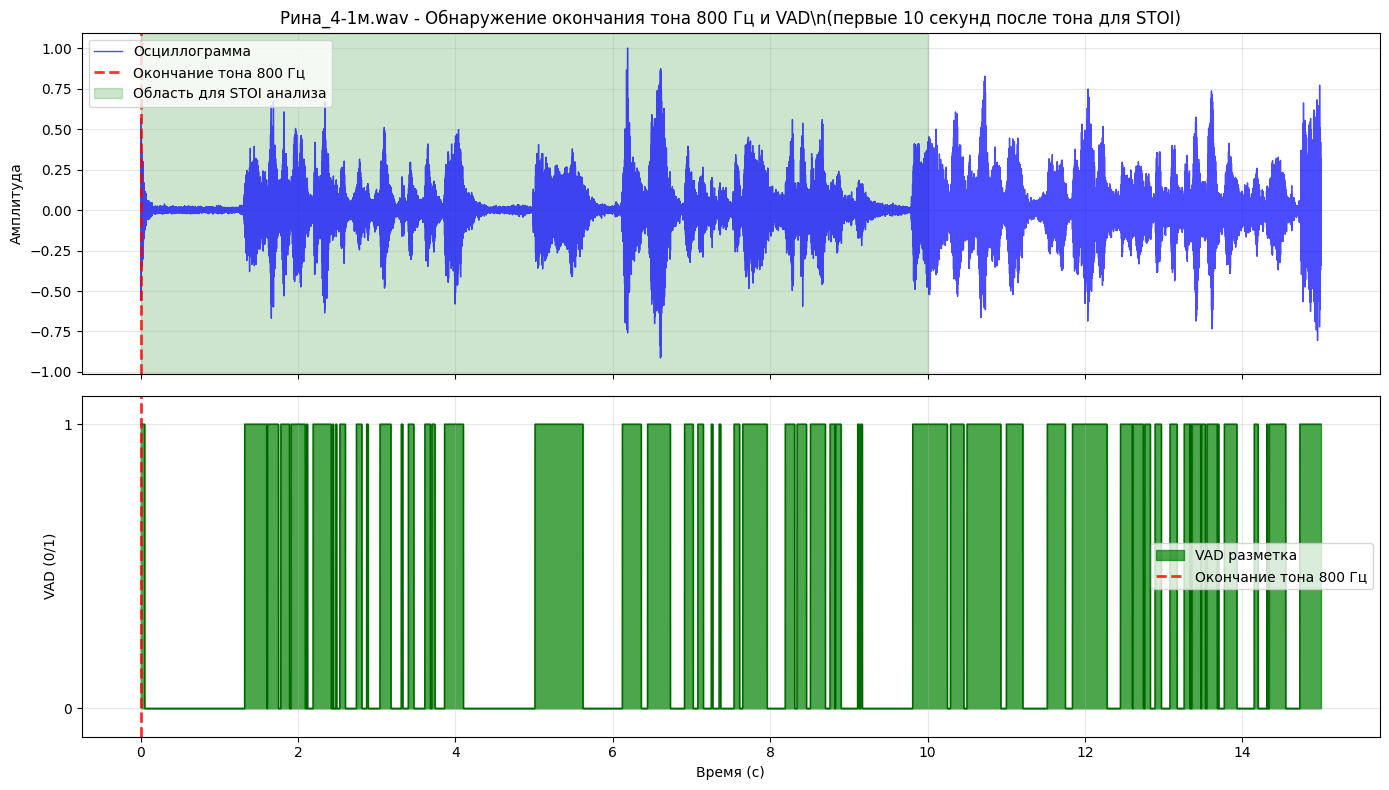

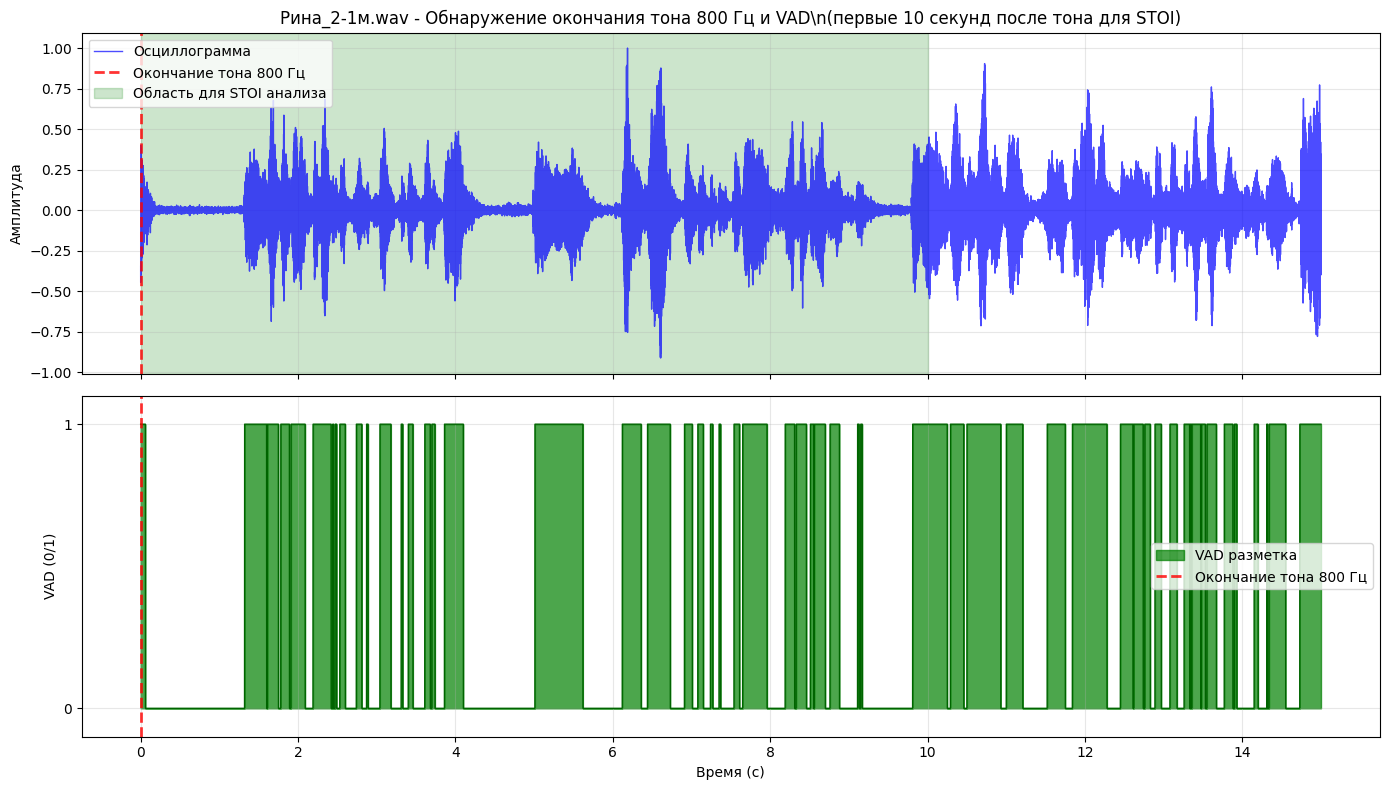

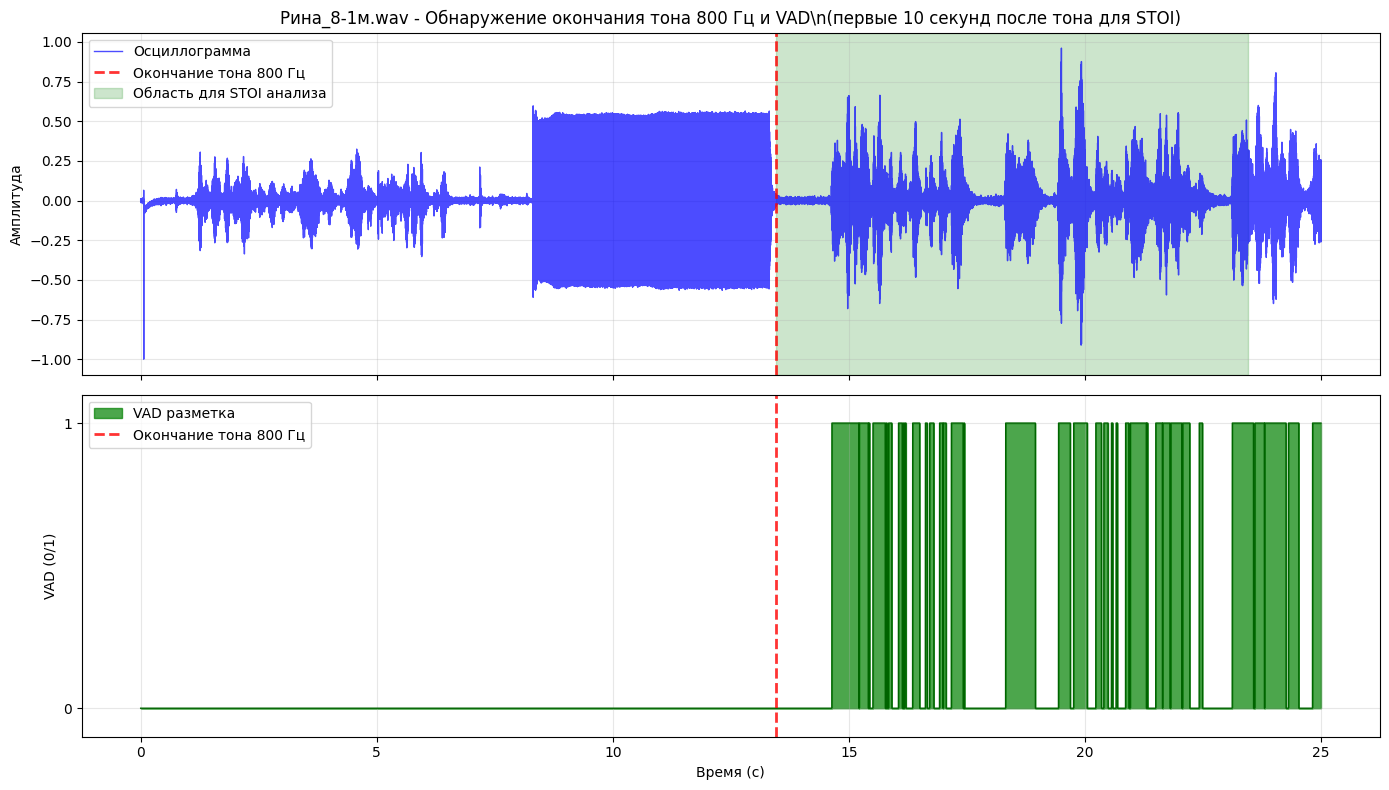

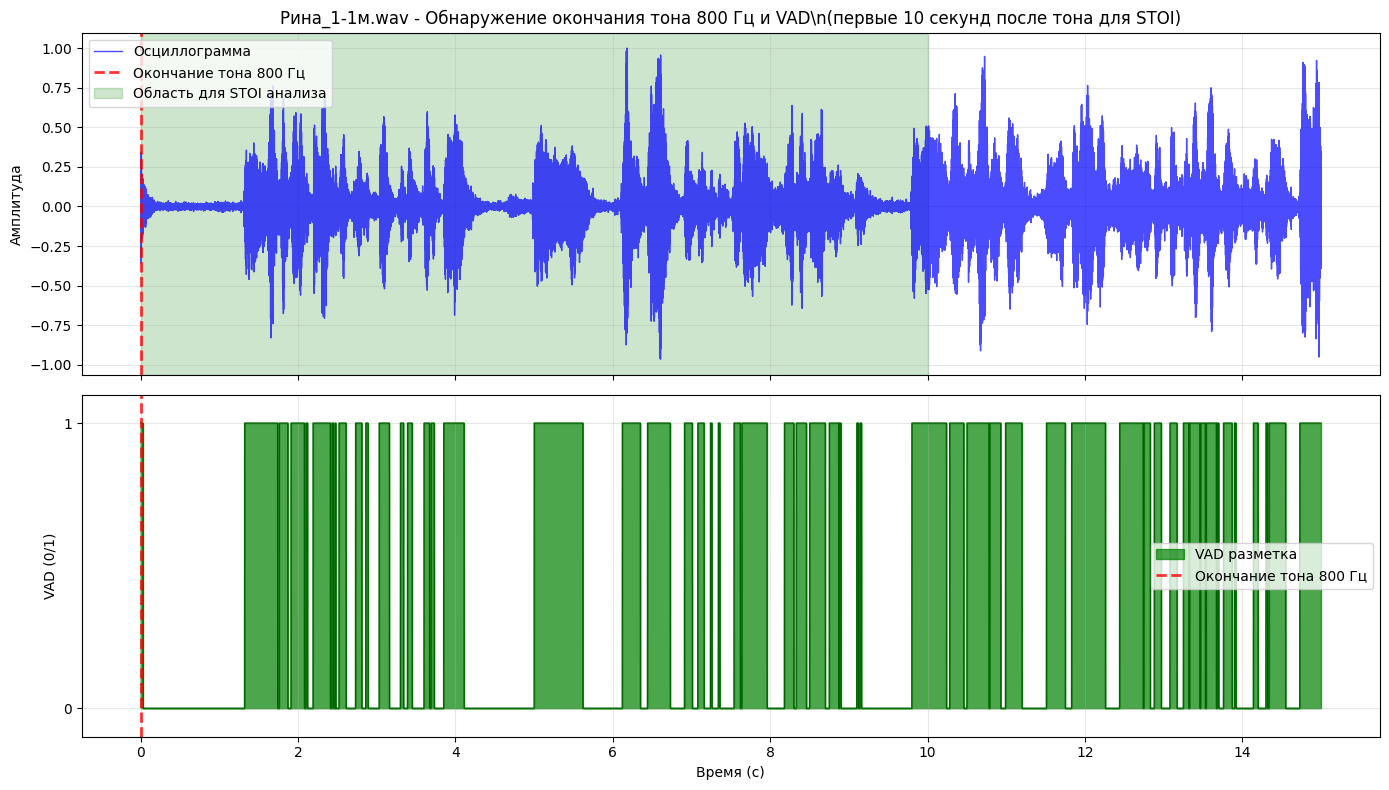

Рина_4-1м.wav: STOI = 0.6956
Рина_2-1м.wav: STOI = 0.7087
Рина_8-1м.wav: STOI = 0.0345
Рина_1-1м.wav: STOI = 1.0000
Средний STOI: 0.6097
Лучший результат: Рина_1-1м.wav - STOI = 1.0000
Худший результат: Рина_8-1м.wav - STOI = 0.0345


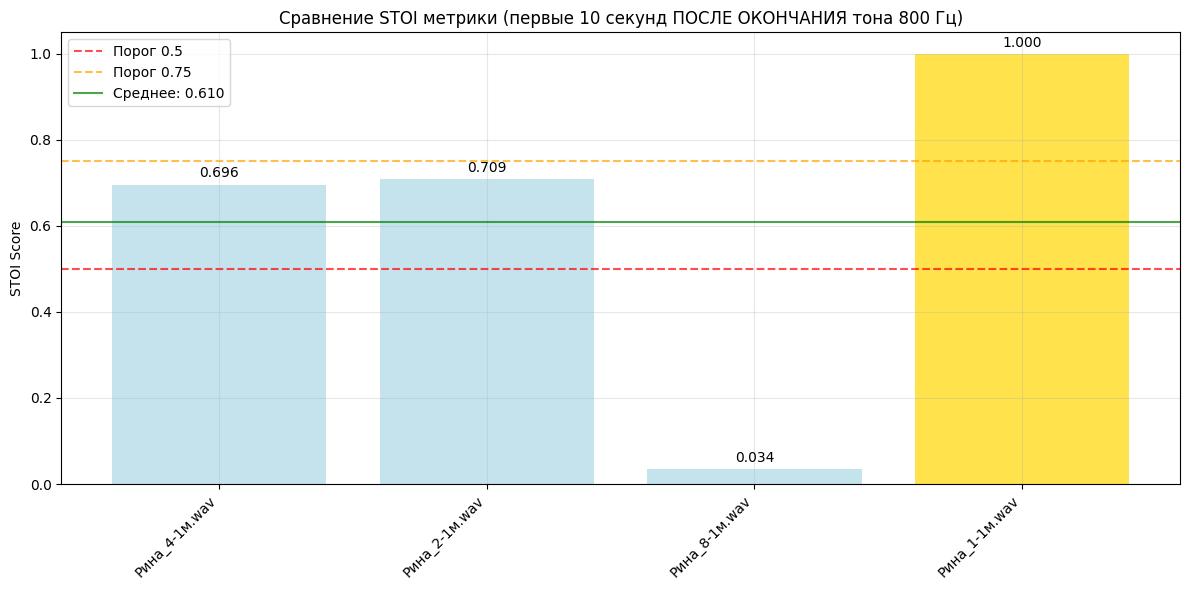

In [15]:
path_to_wav_folder = '/home/danya/datasets/speech_thesisis/'
results, stoi_results = process_all_files_with_stoi_after_tone(path_to_wav_folder)